# Model Bootstrapping
In this notebook, we'll use **cluster bootstrapping** to assign measures of accuracy to sample estimates of our OLS coeffecients. The standard deviation of the boot-strapped coeffecient estimates will give us the standard error and 1.96 * SE will give us a confidence interval. A combination of N, SE, and the estimate will give us the Z score from which we can get a p-value. 

>We're going to **cluster bootstrap** because we believe our errors are correlated within the individual traveler level. Because of this, we'll bootstrap individuals and not rows: that might mean we have all of Scott's trips 3 times in one bootstrapped iteration of the data, and none of Austin's, for example.

Once we've got our model, we'll plug in simulated observations to get predicted values. We'll create a simulated observation for each combination of our interaction term of interest (i.e. the fare type and booking lead time). For each of these simulated observations, the control variables will be set equal to their expected value (i.e. the mean for the continuous predictors and the mode for the categorical predictors). Do this will give us a prediction for each type of fare at each point in time. Then we will plot lead time on the x axis and predictions on y, with lines in the color of the fare type. 

## Imports

In [1]:
import itertools
import os
import pickle
import random
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from scipy.stats import sem, t, norm
from scipy import mean
import seaborn as sns
import statsmodels.formula.api as sm

from models.models import Segment 

## Fit Model One

In [2]:
#Using model 1
model = Segment().model_1()

#this is the data we are using 
df = model.model_data

formula = (
           "cost_per_mile ~   market_share_log  + month + day_of_week + C(Year) + "
           "no_CA_award + booking_days_standarized + booking_days_standarized*C(fare_type, "
           "Treatment(reference='Dash CA')) + city_pair_code + self_booking_indicator"
          )
#this model uses the standarized booking advanced days
result = sm.ols(formula = formula, data = df).fit()
result.summary()

preparing data


/Users/charlessmcallister/.local/share/virtualenvs/travel-project-report-S1-ev3MJ/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (7,8,15,16,24,25,26,27,71,72,74,75,79,85,130) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_per_mile   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1944.
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        08:19:33   Log-Likelihood:                 41447.
No. Observations:               26189   AIC:                        -8.269e+04
Df Residuals:                   26086   BIC:                        -8.185e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================
                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          0.4296      0.004    119.892      0.000       0.423       0.437
month[T.August]                                                                   -0.0015      0.001     -1.053      0.292      -0.004       0.001
month[T.December]                                                                  0.0047      0.002      2.516      0.012       0.001       0.008
month[T.February]                                                                 -0.0076      0.002     -4.988      0.000      -0.011      -0.005
month[T.January]                                                                  -0.0050      0.002     -3.011      0.003      -0.008      -0.002
month[T.July]                                                                      0.0053      0.002      3.281      0.001       0.002       0.008
month[T.June]                                                                      0.0040      0.002      2.656      0.008       0.001       0.007
month[T.March]                                                                     0.0023      0.001      1.621      0.105      -0.000       0.005
month[T.May]                                                                      -0.0074      0.001     -5.065      0.000      -0.010      -0.005
month[T.November]                                                                  0.0089      0.002      5.244      0.000       0.006       0.012
month[T.October]                                                                   0.0070      0.002      4.256      0.000       0.004       0.010
month[T.September]                                                                 0.0019      0.002      1.250      0.211      -0.001       0.005
day_of_week[T.Monday]                                                             -0.0035      0.001     -3.409      0.001      -0.005      -0.001
day_of_week[T.Saturday]                                                           -0.0049      0.002     -2.001      0.045      -0.010     -0.0001
day_of_week[T.Sunday]                                                              0.0002      0.001      0.179      0.858      -0.002       0.003
day_of_week[T.Thursday]                                                           -0.0009      0.001     -0.891      0.373      -0.003       0.001
day_of_week[T.Tuesday]                                                            -0.0073      0.001     -6.597      0.000      -0.009      -0.005
day_of_week[T.Wednesday]                                                          -0.0047      0.001     -4.129      0.000      -0.007      -0.

## Bootstrap Resampling
Adjust `n` below to change the number of iterations.

In [3]:
# add in placeholder col for the traveler until I updated models.py
df['traveler'] = [random.choice(range(1000)) for i in range(df.shape[0])]

In [4]:
def cluster_bootstrap(df, cluster = 'traveler'):
    '''
    cluster resample with replacement from a dataframe
    '''
    n_rows = df.shape[0]
    unique_travelers = df[cluster].unique()

    data = []
    row_counter = 0
    while row_counter < n_rows:
        random_traveler = random.choice(unique_travelers)
        traveler_df = df[df[cluster] == random_traveler]
        data.append(traveler_df)
        row_counter += traveler_df.shape[0]

    bootstrapped_df = pd.concat(data)
    
    return bootstrapped_df

In [5]:
def gen_new_data(combinations, new_sample, exog_cont, exog_fact, booking_days_col):
    '''
    Genereates the simulated observations where all of the control variables equal their expected value
    and each combination of our interaction term is represented.
    '''
    new_data = []
    for c in combinations:
        #they all get the expected value for their control vars
        controls = list(new_sample.values[0])
        exog = list(c)
        row = controls + exog
        new_data.append(row)

    new_data_df = pd.DataFrame(new_data)
    new_data_df.columns = exog_cont + exog_fact + ['fare_type', booking_days_col]
    #this needs to be a float and not object in order to pass it into the model for predictions
    new_data_df[booking_days_col] = new_data_df[booking_days_col].astype(float)

    return new_data_df

In [6]:
def calc_ci(data, confidence = .95):
    '''
    given a series of data, calculate a 95% CI, returning the upper and lower bounds along with the std_err
    and p_value
    '''
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    z = t.ppf((1 + confidence) / 2, n - 1)
    h = std_err * z

    start = m - h
    end = m + h
    
    p_value = norm.sf(abs(z))*2
    
    return start, end, std_err, p_value

In [7]:
def bootstrap_resample(df, formula, original_model, n = 10000, booking_days_col = 'booking_days_standarized'):
    '''
    Given a dataframe and OLS formula, bootstrap n times. Fit a model with each iteration, saving the results.
    Also randomly generate a new data point with the expected value for the control variables and randomly generated
    values for the variables of interest. Save that predicted value along with the randomly adjusted inputs.
    '''
    #specify control vars of interest from the model specification, distinguishing between factors and continuous vars
    exog_cont = ['cost_per_mile', 'market_share_log']
    exog_fact = ['month', 'day_of_week', 'Year', 'no_CA_award', 'city_pair_code', 'self_booking_indicator']

    #get expected values for these control variables
    fixed_exog_cont = pd.DataFrame(df[exog_cont].mean()).transpose()
    fixed_exog_fact = df[exog_fact].mode()

    #combine these expected values into a df that'll be re-used in each iteration
    new_sample = pd.concat([fixed_exog_cont, fixed_exog_fact], axis = 1)
    #get list of unique fare types to randomly draw from in each iteration
    fare_types = df['fare_type'].unique()
    #concat combinations of fare_type:booking_days_standardized to control vars
    booking_days_col_unique_values = df[booking_days_col].unique()
    combinations = list(itertools.product(fare_types, booking_days_col_unique_values))
    new_data_df = gen_new_data(combinations, new_sample, exog_cont, exog_fact, booking_days_col)
    
    #create a dict where the keys are the original model's coeffecients
    params = {k:[] for k in original_model.params.to_dict().keys()}
    y_preds = {k:[] for k in combinations}
    for i in range(n):
        #create bootstrap sample and fit a model using that sample
        bootstrapped_df = cluster_bootstrap(df)
        bootstrapped_result = sm.ols(formula = formula, data = bootstrapped_df).fit()

        #get the coeffecients
        _params = bootstrapped_result.params.to_dict()
        for k in _params:
            params[k].append(_params[k])

        y_pred = bootstrapped_result.predict(new_data_df)
        for combination, y_hat in zip(combinations, y_pred):
            y_preds[combination].append(y_hat)
        
        #log progress
        if i % 1000 == 0 and i != 0:
            print( f"Done with {i} iterations.")
    
    param_stats = {k:calc_ci(v) for k,v in params.items()}
    y_pred_stats = {k:calc_ci(v) for k,v in y_preds.items()}
    
    return param_stats, y_pred_stats, y_preds

In [8]:
#this takes a long time. Could possibly refactor to improve performance
param_stats, y_pred_stats, y_preds = bootstrap_resample(df, formula, result, n = 10000)

Done with 1000 iterations.
Done with 2000 iterations.
Done with 3000 iterations.
Done with 4000 iterations.
Done with 5000 iterations.
Done with 6000 iterations.
Done with 7000 iterations.
Done with 8000 iterations.
Done with 9000 iterations.


In [9]:
#Write results
with open('param_stats.pkl', 'wb') as f:
    pickle.dump(param_stats, f)
    
with open('y_pred_stats.pkl', 'wb') as f:
    pickle.dump(y_pred_stats, f)
    
with open('y_preds.pkl', 'wb') as f:
    pickle.dump(y_preds, f)

# Plot predicted values
Here we'll unpickle the results and plot the predicted values against the randomly generated `booking_days_standardized` for each `fare_type`.

In [11]:
with open('param_stats.pkl', 'rb') as f:
    param_stats = pickle.load(f)

with open('y_pred_stats.pkl', 'rb') as f:
    y_pred_stats = pickle.load(f)

with open('y_preds.pkl', 'rb') as f:
    y_preds = pickle.load(f)

In [33]:
dfs = []
for k in y_preds:
    _df = pd.DataFrame(y_preds[k])
    _df['Fare Type'] = k[0]
    _df['Booking Lead Time (Standardized)'] = k[1]
    _df = _df.rename({0:'Cost per Mile'}, axis = 1)
    dfs.append(_df)
    
y_pred_df = pd.concat(dfs)

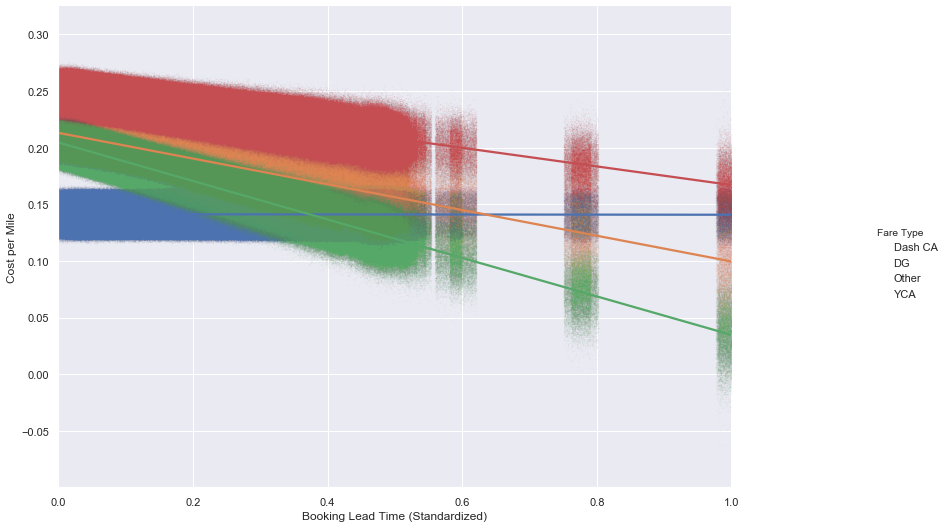

In [54]:
#standardized booking_days
sns.set(color_codes = True)
lm = sns.lmplot(x = "Booking Lead Time (Standardized)",
                y = "Cost per Mile",
                hue = "Fare Type",
                data = y_pred_df,
                x_jitter = .02,
                y_jitter = .02,
                scatter_kws={"s": .0005}, #changes the marker size
                ci = None) 
lm.fig.set_size_inches(15, 8)
lm.set(xlim=(0, 1))

In [ ]:
#save the fig to disk
fig = lm.get_figure()
fig.savefig('Cost per Mile vs Booking Lead Time.png') 